In [10]:
import matplotlib.pyplot as plt
import numpy as np

class CSVPlot():
    def __init__(self, dataset_name, dataset_path):
        self.epsilons = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.5, 1]
        self.attacks = ['Fast Gradient Attack', 'Deep Fool Attack', 'FMN Attack']
        self.models = ['LeNet', 'ConvPara1', 'ConvPara2', 'ConvPara3', 'ConvLif1', 'ConvLif2']
        self.dataset_name = dataset_name

        self.model_perf = {f'{model}':[] for model in self.models}
        
        with open(dataset_path, 'r') as fh:
            for ind, line in enumerate(fh):
                self.model_perf[self.models[ind]] = [float(x) for x in line.split("\t")]

    def plotRobustnessPerEpsilon(self, attack: int):
        data = {model:[] for model in self.models}

        for i in self.models:
            model_perf = self.model_perf[i]
            match attack:
                case 0:
                    data[i] = model_perf[0::3]
                    baseline = data['LeNet']
                    np_data = np.array(data[i])
    
                    plt.plot(self.epsilons, (np.divide(baseline, np_data)-1)*100, label = f'{i}')
                    plt.title(f'Fast Gradient Attack, {self.dataset_name.upper()}')
                case 1:
                    data[i] = model_perf[1::3]
                    baseline = data['LeNet']
                    np_data = np.array(data[i])

                    plt.plot(self.epsilons, (np.divide(baseline, np_data)-1)*100, label = f'{i}')
                    plt.title(f'Deep Fool Attack, {self.dataset_name.upper()}')
                case 2:
                    data[i] = model_perf[2::3]
                    baseline = data['LeNet']
                    np_data = np.array(data[i])

                    plt.plot(self.epsilons, (np.divide(baseline, np_data)-1)*100, label = f'{i}')
                    plt.title(f'FMN Attack, {self.dataset_name.upper()}')

        plt.legend()
        plt.xlabel('Epsilon values')
        plt.ylabel('Attack Robustness Gain Percentage')
        plt.xscale('log')
        plt.show()

        return None
    
    def plotRobustnessPerLayer(self, epsilon=None):
        epsilon_ind = self.epsilons.index(epsilon)
        res_para = np.zeros((4, len(self.attacks)))
        res_lif = np.zeros((3, len(self.attacks)))
        j = k = 1

        for i in self.models:
            model_perf = self.model_perf[i]
            n = 3
            if i == 'ConvPara1' or i == 'ConvPara2' or i == 'ConvPara3':
                res_para[j] = [model_perf[i * n:(i + 1) * n] for i in range((len(model_perf) + n - 1) // n )][epsilon_ind]
                j += 1
            elif i == 'ConvLif1' or i == 'ConvLif2':
                res_lif[k] = [model_perf[i * n:(i + 1) * n] for i in range((len(model_perf) + n - 1) // n )][epsilon_ind]
                k += 1
            else:
                res_lif[0] = [model_perf[i * n:(i + 1) * n] for i in range((len(model_perf) + n - 1) // n )][epsilon_ind]
                res_para[0] = [model_perf[i * n:(i + 1) * n] for i in range((len(model_perf) + n - 1) // n )][epsilon_ind]

        res_lif = np.transpose(res_lif)
        res_para = np.transpose(res_para)

        plt.plot(range(res_para.shape[1]), res_para[0], label = 'Fast Gradient Attack: ParaLif')
        plt.plot(range(res_lif.shape[1]), res_lif[0], label = 'Fast Gradient Attack: Lif')
        plt.plot(range(res_para.shape[1]), res_para[1], label = 'Deep Fool Attack: ParaLif')
        plt.plot(range(res_lif.shape[1]), res_lif[1], label = 'Deep Fool Attack: Lif')
        plt.plot(range(res_para.shape[1]), res_para[2], label = 'FMN Attack: ParaLif')
        plt.plot(range(res_lif.shape[1]), res_lif[2], label = 'FMN Attack: Lif')
        plt.legend()
        plt.xticks([0, 1, 2, 3])
        plt.xlabel('Number of FF Layers Replaced By ParaLif / Lif')
        plt.ylabel('Attack Success Rate')
        plt.ylim((-.05, 1.05))
        plt.title(f'{self.dataset_name.upper()}, Epsilon: {epsilon}')
        plt.show()


        return None


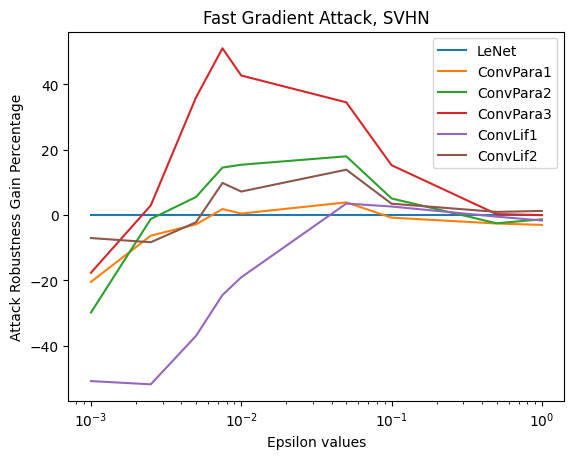

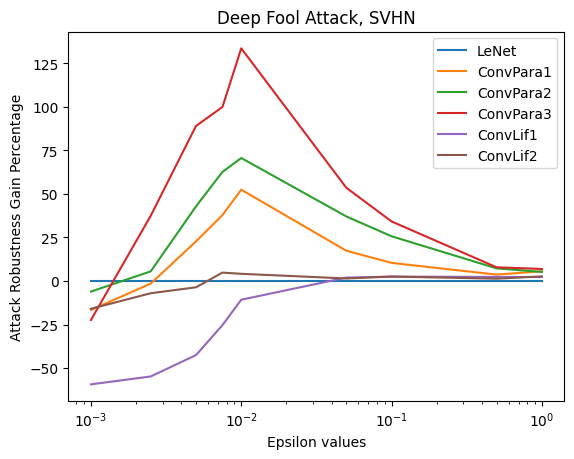

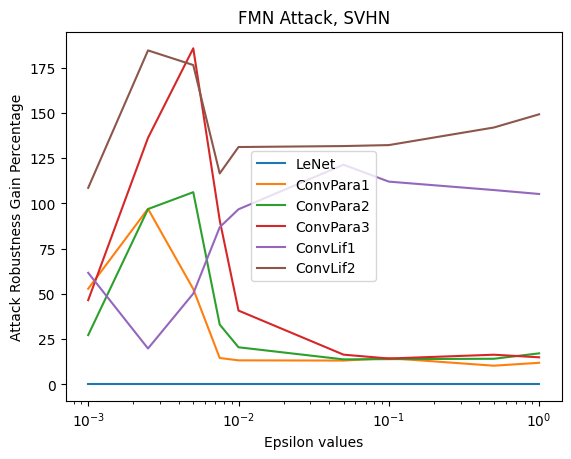

'test = CSVPlot(dataset_name[input], dataset_path[input])\ntest.plotRobustnessPerLayer(epsilon)'

In [21]:
dataset_name = ['mnist','fashion','kmnist','svhn']
dataset_path = ['mnist_res.txt', 'fashion_res.txt', 'kmnist_res.txt', 'svhn_res.txt']
input = 3
attack = 0
epsilon = 0.5

for i in range(3):
    test = CSVPlot('svhn', 'svhn_res.txt')
    test.plotRobustnessPerEpsilon(i)

'''for i in range(len(dataset_name)):
    test = CSVPlot(dataset_name[i], dataset_path[i])
    test.plotRobustnessPerEpsilon(attack)'''

'''test = CSVPlot(dataset_name[input], dataset_path[input])
test.plotRobustnessPerLayer(epsilon)'''
